In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# experimenting... https://docs.kidger.site/jaxtyping/api/runtime-type-checking/
from jaxtyping import install_import_hook
from beartype import beartype as typechecker
with install_import_hook("main", "beartype.beartype"):
    from twm import utils

    from twm.config import CONFIGS

    

In [3]:
from copy import deepcopy
config = deepcopy(CONFIGS['test'])
config.update({
    'game': 'Breakout', 
    # 'seed': args.seed, 'model_device': args.device, 'buffer_device': buffer_device,
    # 'cpu_p': args.cpu_p, 'save': args.save
})
config

{'buffer_capacity': 100000,
 'buffer_temperature': 20.0,
 'buffer_prefill': 5000,
 'budget': 1000000000,
 'pretrain_budget': 50000,
 'pretrain_obs_p': 0.6,
 'pretrain_dyn_p': 0.3,
 'eval_every': 500,
 'eval_episodes': 10,
 'final_eval_episodes': 100,
 'env_frame_size': 64,
 'env_frame_skip': 4,
 'env_frame_stack': 4,
 'env_grayscale': True,
 'env_noop_max': 30,
 'env_time_limit': 2700,
 'env_episodic_lives': True,
 'env_reward_transform': 'tanh',
 'env_discount_factor': 0.99,
 'env_discount_lambda': 0.95,
 'wm_batch_size': 100,
 'wm_sequence_length': 16,
 'wm_train_steps': 1,
 'wm_memory_length': 16,
 'wm_discount_threshold': 0.1,
 'z_categoricals': 32,
 'z_categories': 32,
 'obs_channels': 48,
 'obs_act': 'silu',
 'obs_norm': 'none',
 'obs_dropout': 0,
 'obs_lr': 0.0001,
 'obs_wd': 1e-06,
 'obs_eps': 1e-05,
 'obs_grad_clip': 100,
 'obs_entropy_coef': 5,
 'obs_entropy_threshold': 0.1,
 'obs_consistency_coef': 0.01,
 'obs_decoder_coef': 1,
 'dyn_embed_dim': 256,
 'dyn_num_heads': 4,
 'd

In [4]:
noop_max = 0 if eval else config['env_noop_max']
env = utils.create_atari_env(
    config['game'], noop_max, config['env_frame_skip'], config['env_frame_stack'],
    config['env_frame_size'], config['env_episodic_lives'], config['env_grayscale'], config['env_time_limit'])
obs, _ = env.reset()
obs.shape

AttributeError: module 'twm.utils' has no attribute 'create_atari_env'

In [14]:
# # Create environment
# from craftax.craftax_env import make_craftax_env_from_name
# env = make_craftax_env_from_name("Craftax-Symbolic-v1", auto_reset=True)
# env_params = env.default_params

# import jax
# rng = jax.random.PRNGKey(0)
# rng, _rng = jax.random.split(rng)
# rngs = jax.random.split(_rng, 3)
# rngs

# # Get an initial state and observation
# obs, state = env.reset(rngs[0], env_params)

# # Pick random action
# action = env.action_space(env_params).sample(rngs[1])

# # Step environment
# obs, state, reward, done, info = env.step(rngs[2], state, action, env_params)

# action.shape, obs.shape, reward, done, info

Loading textures from cache


/media/wassname/SGIronWolf/projects5/worldmodels/twm/.venv/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)


((),
 (8268,),
 Array(0., dtype=float32),
 Array(False, dtype=bool),
 {'discount': Array(1., dtype=float32, weak_type=True)})

(array([[7.96e+03, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 3.04e+02],
        [7.96e+03, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 3.04e+02],
        [7.96e+03, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 3.04e+02],
        [7.96e+03, 3.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 3.04e+02]]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <a list of 4 BarContainer objects>)

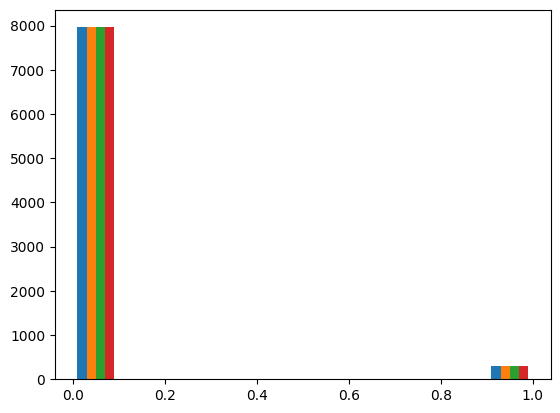

In [20]:
from matplotlib import pyplot as plt
plt.hist(obs)

In [18]:
from twm.envs.craftax import create_craftax_env
noop_max = 0 if eval else config['env_noop_max']
env = create_craftax_env(
    config['game'], noop_max, config['env_frame_skip'], config['env_frame_stack'],
    config['env_frame_size'], config['env_episodic_lives'], config['env_grayscale'], config['env_time_limit'])
obs, _ = env.reset()
obs.shape

(4, 8268)

## Encoder decoder

In [22]:
# A trainable layer that takes us from the obs input to the latent space
from twm import nets

import torch
import torch.nn.functional as F
from torch import nn, Tensor

z_dim = 32
num_channels = 2
dropout_p= 0
h = 3
norm = 'none'
activation = 'relu'
encoder = nn.Sequential(
    nets.CNN(num_channels, [h, h * 2, h * 4], h * 8,
                [4, 4, 4, 4], [2, 2, 2, 2], [0, 0, 0, 0], activation, norm=norm, post_activation=True),
    nn.Flatten(),
    nets.MLP((h * 8) * 2 * 2, [512, 512], z_dim, activation, norm=norm, dropout_p=dropout_p)
)

# no norm here
decoder = nn.Sequential(
    nets.MLP(z_dim, [], (h * 16) * 1 * 1, activation, dropout_p=dropout_p, post_activation=True),
    nn.Unflatten(1, (h * 16, 1, 1)),
    nets.TransposeCNN(h * 16, [h * 4, h * 2, h], num_channels, [5, 5, 6, 6], [2, 2, 2, 2], [0, 0, 0, 0],
                        activation, final_bias_init=0.5)
)

x = torch.randn(1, num_channels, 64, 64)
z = encoder(x)
x_hat = decoder(z)
x.shape, z.shape, x_hat.shape

(torch.Size([1, 2, 64, 64]), torch.Size([1, 32]), torch.Size([1, 2, 64, 64]))

In [30]:
z_dim = 32
num_channels = 4 * 8943
dropout_p= 0
h = 32
norm = 'none'
activation = 'relu'
encoder = nn.Sequential(
    nn.Flatten(),
    nets.MLP(num_channels, [512, 512], z_dim, activation, norm=norm, dropout_p=dropout_p)
)
print(encoder)

# no norm here
decoder = nn.Sequential(
    nets.MLP(z_dim, [], (h * 16) * 1 * 1, activation, dropout_p=dropout_p, post_activation=True),
    nn.Unflatten(1, (h * 16, 1, 1)),
    nets.TransposeCNN(h * 16, [h * 4, h * 2, h], num_channels, [5, 5, 6, 6], [2, 2, 2, 2], [0, 0, 0, 0],
                        activation, final_bias_init=0.5)
)

x = torch.randn(1, 4, 8943)
z = encoder(x)
x_hat = decoder(z)
x.shape, z.shape, x_hat.shape

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): MLP(
    (act): ReLU()
    (linear1): Linear(in_features=35772, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=32, bias=True)
  )
)


(torch.Size([1, 4, 8943]), torch.Size([1, 32]), torch.Size([1, 35772, 64, 64]))

In [89]:
x = torch.randn(1, 10)
l1 = nn.Linear(10, 5, bias=True)
l1 = torch.nn.utils.weight_norm(l1, 'weight', 1)
# l1.weight.data = l1.weight.data / l1.weight.data.norm(dim=1, keepdim=True)

/media/wassname/SGIronWolf/projects5/worldmodels/twm/.venv/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [91]:
class InvLinear(nn.Module):
    """This in an inverse to another linear layer"""

    def __init__(self, linear):
        super().__init__()
        self.linear = linear

    def forward(self, x):
        if self.linear.bias is not None:
            print(self.linear.bias)
            x = x - self.linear.bias
        return F.linear(x, self.linear.weight.T)
        # return x @ self.linear.weight.data.T
    


l2 = InvLinear(l1)

y = l1(x)
z = l2(y)
x.shape, z.shape, (x - z).abs().mean()

Parameter containing:
tensor([-0.1614, -0.0878, -0.1413,  0.0030, -0.0044], requires_grad=True)


(torch.Size([1, 10]),
 torch.Size([1, 10]),
 tensor(0.7295, grad_fn=<MeanBackward0>))

In [64]:
x, z

(tensor([[-1.8850, -0.2433,  0.1431, -2.8678, -0.7606, -0.4953, -0.9287, -1.1206,
          -0.6896, -0.2894]]),
 tensor([[-0.1270, -0.1363, -0.0358, -0.2114, -0.2823,  0.0127,  0.0935,  0.0243,
          -0.2868, -0.0372]], grad_fn=<MmBackward0>))

In [97]:
z_dim = 32
frames = 4
num_channels = 4 * 8943
dropout_p= 0
h = 32
norm = 'none'
activation = 'relu'

# note could also tie weight, but that would limit flexibility
encoder = nn.Sequential(
    nn.Flatten(),
    nets.MLP(num_channels, [512, 512], z_dim, activation, norm=norm, dropout_p=dropout_p)
)
print(encoder)

# no norm here
decoder = nn.Sequential(
    nets.MLP(z_dim, [], num_channels, activation, dropout_p=dropout_p, post_activation=True),
    nn.Unflatten(1, (4, num_channels//4)),
)

x = torch.randn(1, 4, 8943)
z = encoder(x)
x_hat = decoder(z)
x.shape, z.shape, x_hat.shape

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): MLP(
    (act): ReLU()
    (linear1): Linear(in_features=35772, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=32, bias=True)
  )
)


(torch.Size([1, 4, 8943]), torch.Size([1, 32]), torch.Size([1, 4, 8943]))

In [3]:
from tqdm import tqdm
with tqdm(total=100) as pbar:
    for i in range(100):
        pbar.update(1)

100%|██████████| 100/100 [00:00<00:00, 168243.24it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
